# Automate closed-loop hardware optimization of quantum devices
**Closed-loop optimization framework**

The Q-CTRL Python package contains automated closed-loop optimization tools that do not require a complete understanding of the workings of your quantum system. These tools allow you to run optimizations while simultaneously obtaining new experimental data.

In particular, you can use the automated closed-loop optimizers to create a closed optimization loop where the optimizer communicates with the experimental apparatus without your direct involvement. In this kind of setting, your experimental apparatus produces an initial set of results, which it sends to the optimizer. Using this information, the optimizer produces a set of improved test points that it recommends back to the experimental apparatus. The results corresponding to these test points are resent to the optimizer, and the cycle repeats itself until any of the results has a sufficiently low cost function value, or until it meets any other ending condition that you imposed. This setup is illustrated in the figure below.
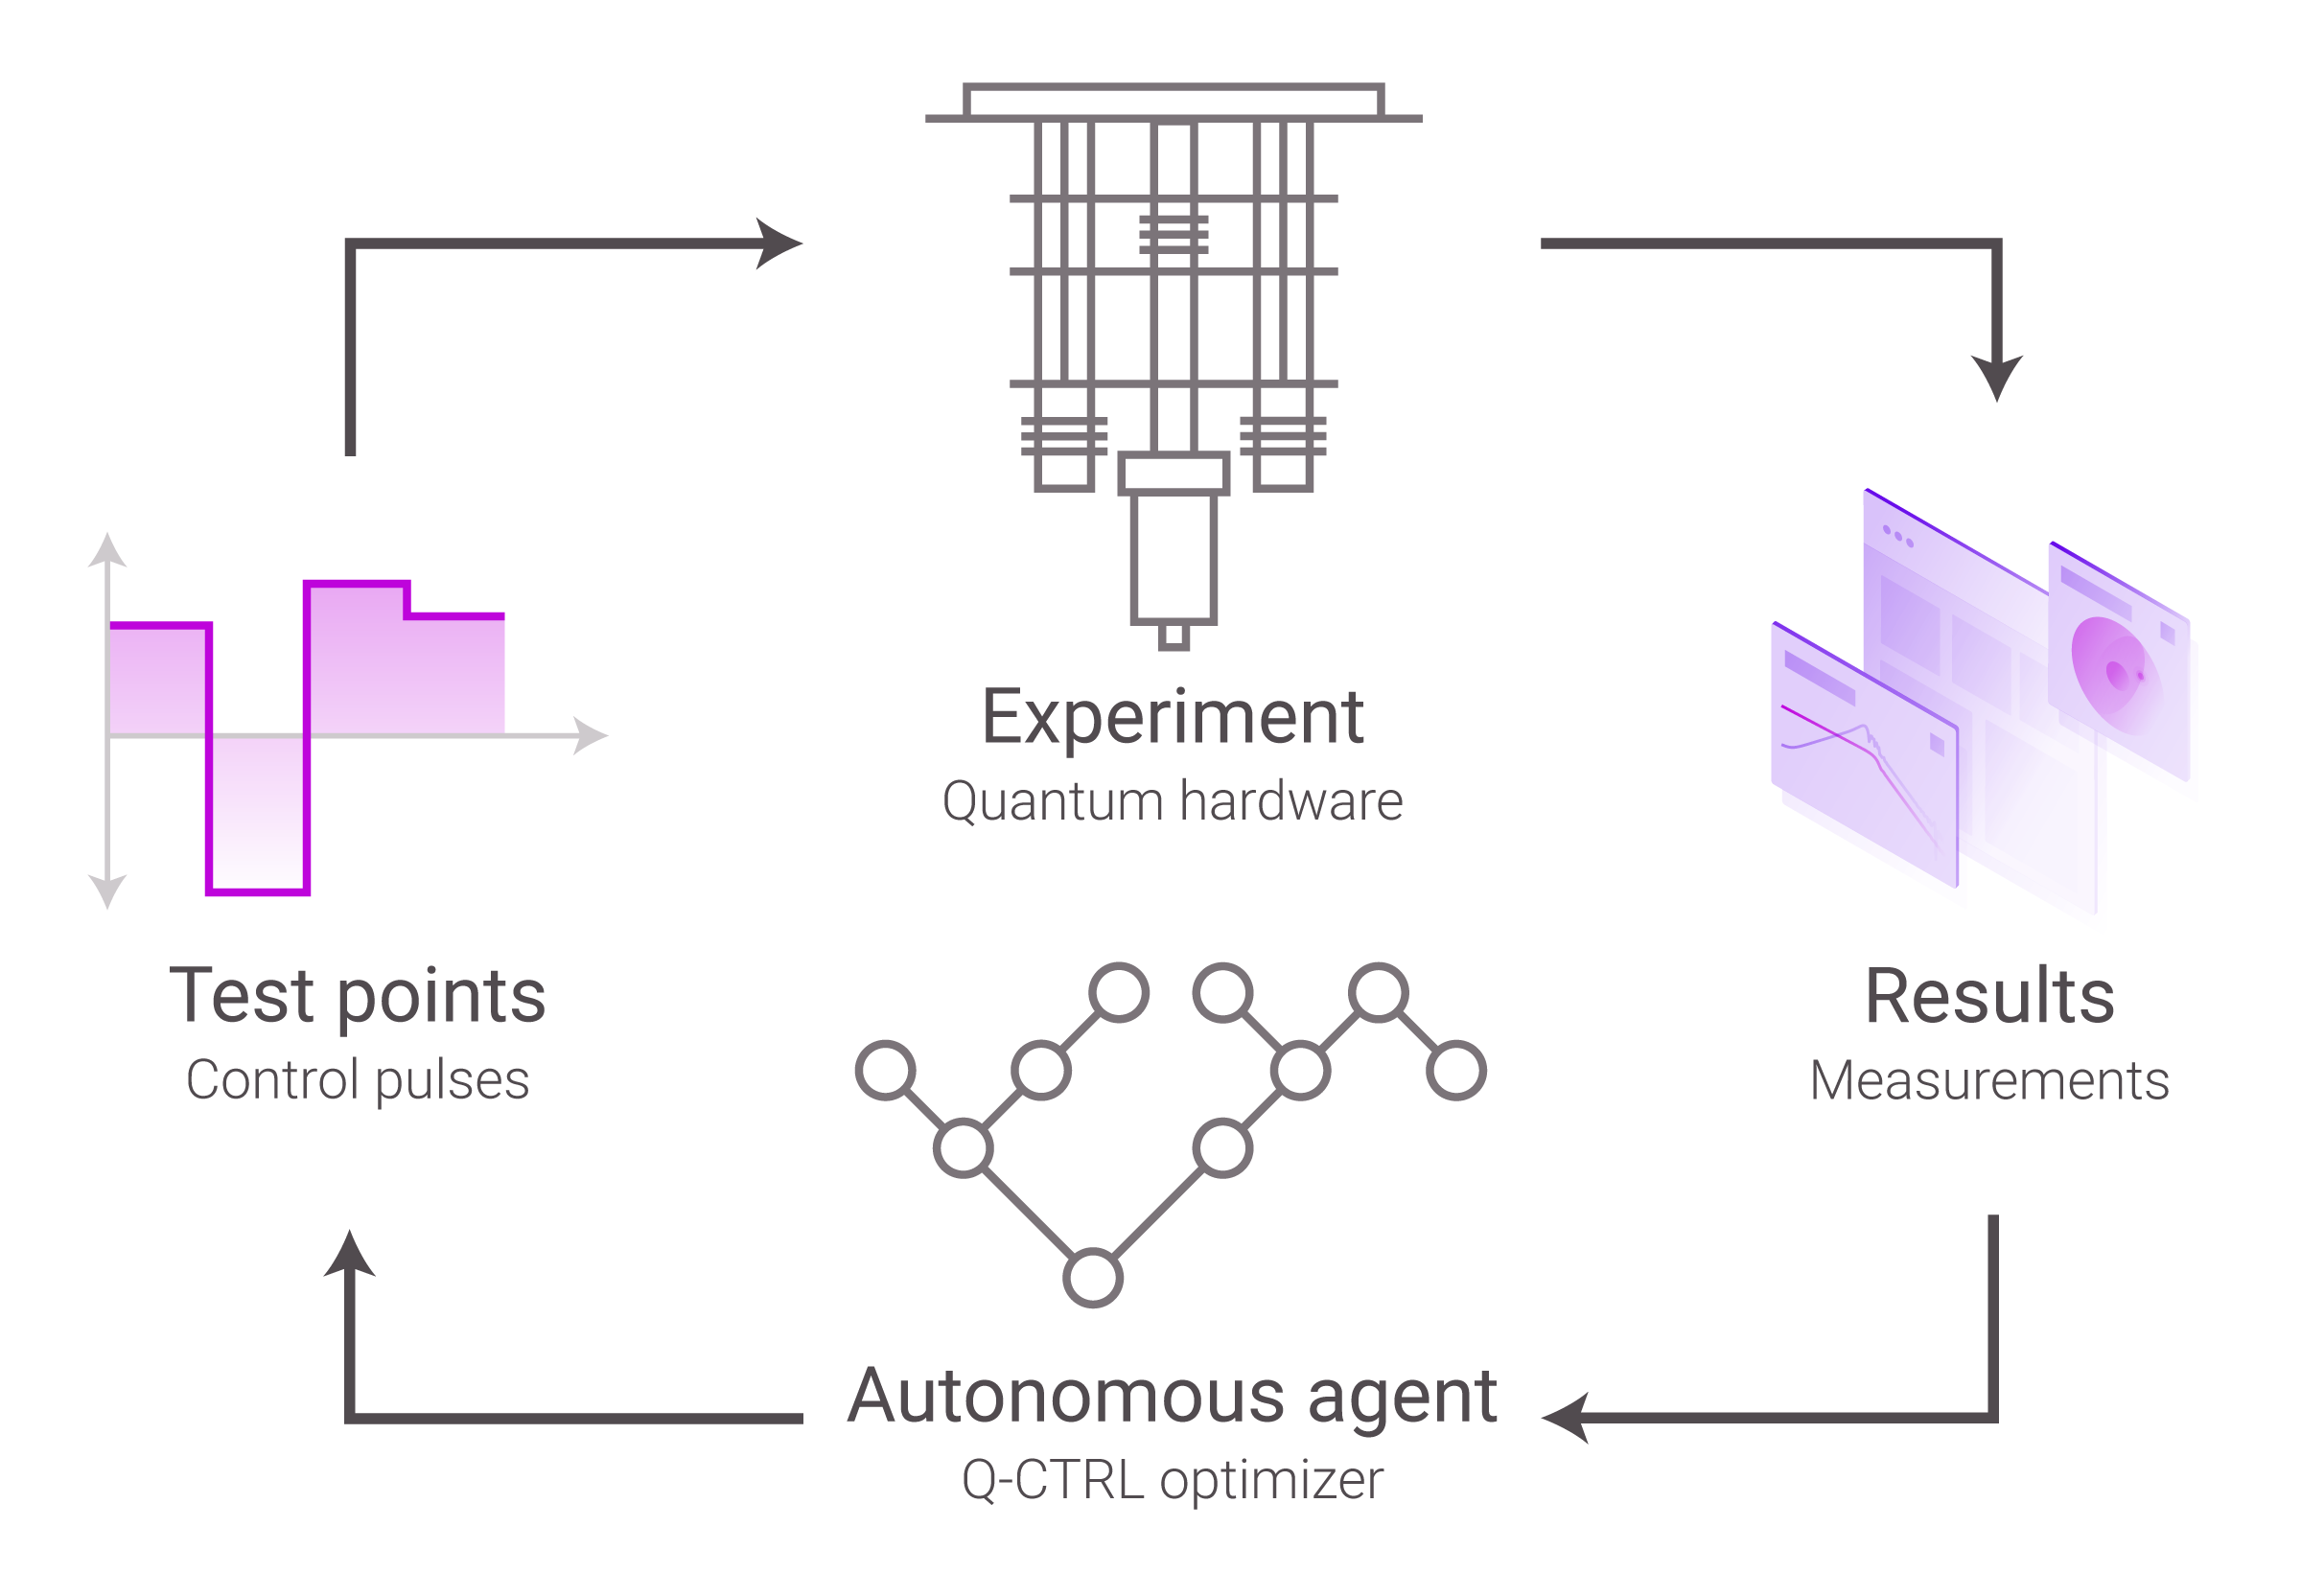

This user guide shows how you can find optimal solutions using the automated closed-loop optimizer of the Q-CTRL Python package, either as a standalone tool, or together with a third-party program (M-LOOP) to manage the experiments. Using the Q-CTRL Python package directly provides maximum flexibility, and in particular allows you to batch requests to your apparatus, which can lead to significant speed improvements if your apparatus can run multiple experiments in parallel or in quick succession (for example a cloud quantum computer that allows multiple independent jobs to be passed in a single request in the queue). If your apparatus does not support this type of batching, you can achieve a simpler integration by using M-LOOP, which handles the optimization loop for you.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Start a session with the API.
qctrl = Qctrl()

## Worked example: Optimal controls with incomplete knowledge about the system

Consider a system whose precise Hamiltonian is unknown to you. Suppose you want to craft an optimal pulse without having to first learn the details of the dynamics of the system. Specifically, suppose you want to create an X gate but your Hamiltonian contains unknown terms:

$$ H(t) = \frac{\Omega(t)}{2} \left( \sigma_x + Q_\text{unknown} \right). $$

In the previous equation, $\Omega(t)$ are the control pulses, and $Q_\textrm{unknown}$ are extra unknown terms of the operator. This worked example shows how you can find the optimal pulse for this system without having to ever learn the form of this extra term.

### Setting up an interface with the experiments

The first thing you'll need is a way of obtaining experimental results for each test point that the automated closed-loop optimizer requests. In a practical situation, you'll be obtaining this data from your experimental equipment. In this example, it suffices to set up a function that simulates the results of the experiment.  To keep the example simple, suppose that the unknown terms have the following arbitrary form:

$$ Q_\text{unknown} = \frac{u \sigma_z + \sqrt{1-u^2} (\cos \phi\; \sigma_x + \sin \phi\; \sigma_y)}{4}, $$

where $u$ is a random variable sampled from the interval $[-1, 1]$ and $\phi$ is a random variable sampled from the interval $[-\pi, \pi]$. The values of $u$ and $\phi$ that the function chose randomly in the beginning persist in all the subsequent runs—they're fixed, but unknown to the experimenter.

For more information about how to simulate quantum systems with the Q-CTRL Python package, see the [Simulate quantum dynamics](https://dev.docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics) User guide.

In [2]:
# Define standard matrices.
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)

# Define control parameters.
duration = 1e-6  # s

# Define standard deviation of the errors in the experimental results.
sigma = 0.01

# Create a random unknown operator.
rng = np.random.default_rng(seed=10)
phi = rng.uniform(-np.pi, np.pi)
u = rng.uniform(-1, 1)
Q_unknown = (
    u * sigma_z + np.sqrt(1 - u ** 2) * (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
) / 4


def run_experiments(omegas):
    """
    Simulates a series of experiments where controls `omegas` attempt to apply
    an X gate to a system. The result of each experiment is the infidelity plus
    a Gaussian error.

    In your actual implementation, this function would run the experiment with
    the parameters passed. Note that the simulation handles multiple test points,
    while your experimental implementation might need to queue the test point
    requests to obtain one at a time from the apparatus.
    """
    # Create the graph with the dynamics of the system.
    with qctrl.create_graph() as graph:
        signal = qctrl.operations.pwc_signal(values=omegas, duration=duration)

        hamiltonian = qctrl.operations.pwc_operator(
            signal=signal,
            operator=0.5 * (sigma_x + Q_unknown),
        )

        qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            target_operator=qctrl.operations.target(operator=sigma_x),
            name="infidelities",
        )

    # Run the simulation.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["infidelities"],
    )

    # Add error to the measurement.
    error_values = rng.normal(loc=0, scale=sigma, size=len(omegas))
    infidelities = result.output["infidelities"]["value"] + error_values

    # Return only infidelities between 0 and 1.
    return np.clip(infidelities, 0, 1)

### Obtaining the initial test points

After setting up the experimental interface, you need to obtain a set of initial results. You will use these as the initial input for the automated closed-loop optimization algorithm.

The following code simulates the experiment with different controls to obtain `test_point_count` initial results, including one set of controls that would create the desired gate if no extra terms were present in the Hamiltonian.

In [3]:
# Define the number of test points obtained per run.
test_point_count = 20

# Define number of segments in the control.
segment_count = 10

# Define parameters as a set of controls with piecewise constant segments.
parameter_set = (
    np.pi
    / duration
    * (np.linspace(-1, 1, test_point_count)[:, None])
    * np.ones((test_point_count, segment_count))
)

# Obtain a set of initial experimental results.
experiment_results = run_experiments(parameter_set)

Your task calculate_graph has completed in 4s.


### Setting up the automated closed-loop optimizer

Now that you have a way to obtain results from the experiment, the next step is to feed the results into the automated closed-loop optimizer. To do this, first you need to initialize the optimizer with the configuration that you want for the optimization.

This example uses the object [`qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/closed_loop_optimization_step/GaussianProcessInitializer.html) to set up an automated closed-loop optimization that uses the Gaussian process method (GP). You can use analogous objects to initialize other methods of optimization, although the set of arguments will vary with the method. The [documentation of the `qctrl.types.closed_loop_optimization_step` namespace](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/closed_loop_optimization_step.html) contains information about all the initializer objects.

You must then pass this initializer object to an instance of the [`qctrl.types.closed_loop_optimization_step.Optimizer`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/closed_loop_optimization_step/Optimizer.html), which is an object that keeps track of the settings and current state of the optimization. Your first instance of the `Optimizer` object receives the initializer of the method that you chose (in the case of GP, as the `gaussian_process_initializer` argument), while subsequent instances just need to receive the argument `state`, which is a binary object where the automated closed-loop optimizer stores the current state of the optimization. Note that you must pass exactly one argument to the `Optimizer` at a time.

In [4]:
# Define initialization object for the automated closed-loop optimization.
length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=1e-5,
    upper_bound=1e5,
)
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration,
    upper_bound=5 * np.pi / duration,
)
initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
    length_scale_bounds=[length_scale_bound] * segment_count,
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    gaussian_process_initializer=initializer,
)

### Running the optimization loop

After both the experimental interface and the optimizer have been set up, you can start the loop that performs the optimization. You can do this by calling the function [`qctrl.functions.calculate_closed_loop_optimization_step`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_closed_loop_optimization_step.html) repeatedly. Each call to this function returns an updated `state` that you can pass to the next instance of the `Optimizer`, and provides a new list of parameters to try. After you run another set of experiments, the automated closed-loop optimizer is called again, and the cycle repeats until you have reached the desired value of the cost.

Best infidelity after 0 BOULDER OPAL optimization steps: 0.10028633187622513


Your task calculate_closed_loop_optimization_step has completed in 4s.


Your task calculate_graph has completed in 4s.
Best infidelity after 1 BOULDER OPAL optimization step: 0.05410177428273324


Your task calculate_closed_loop_optimization_step has completed in 4s.


Your task calculate_graph has completed in 4s.
Best infidelity after 2 BOULDER OPAL optimization steps: 0.05410177428273324


Your task calculate_closed_loop_optimization_step has completed in 4s.


Your task calculate_graph has completed in 4s.
Best infidelity after 3 BOULDER OPAL optimization steps: 0.03588406627341298


Your task calculate_closed_loop_optimization_step has completed in 4s.


Your task calculate_graph has completed in 4s.
Best infidelity after 4 BOULDER OPAL optimization steps: 0.03588406627341298


Your task calculate_closed_loop_optimization_step has completed in 4s.


Your task calculate_graph has completed in 4s.
Best infidelity after 5 BOULDER OPAL optimization steps: 0.03588406627341298


Your task calculate_closed_loop_optimization_step has completed in 6s.


Your task calculate_graph has completed in 4s.
Infidelity: 0.0195805238032383


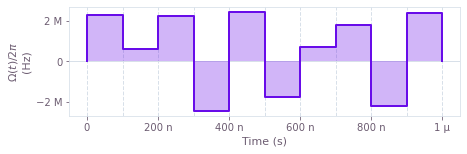

In [5]:
best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3 * sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters),
            cost=cost,
            cost_uncertainty=sigma,
        )
        for parameters, cost in zip(parameter_set, experiment_results)
    ]

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer,
        results=results,
        test_point_count=test_point_count,
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )

    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set)

    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)

### Summary

The automated closed-loop optimization tools from the Q-CTRL Python package allow you to obtain optimal controls even without complete knowledge about the dynamics of the system. In this example, the optimizer obtains optimized controls capable of yielding infidelities below a threshold of three times the standard deviation of the experimental errors, without knowing the exact form of the Hamiltonian.

## Example: Automated closed-loop optimization with M-LOOP

You can further automate the procedure of obtaining experimental test points and running optimizations by using the [M-LOOP package](https://github.com/michaelhush/M-LOOP) together with the [Q-CTRL Python M-LOOP package](https://pypi.org/project/qctrl-mloop/) (`qctrlmloop`), which acts as an interface between M-LOOP and the Q-CTRL Python package. The Q-CTRL Python M-LOOP package (which you can install with `pip install qctrl-mloop`) provides the `QctrlController` class, a controller that accepts an initial instance of the `Optimizer` object and then handles the subsequent calls to the experimental interface, the next steps of the automated closed-loop optimization, and the updates to the `state` of the `Optimizer`. Using the `QctrlController`, you don't need to set up the optimization loop by yourself, and the optimization will run until it meets the conditions that you defined in the arguments of the controller (see the documentation of the [`Controller` base class](https://m-loop.readthedocs.io/en/stable/api/controllers.html) for a description of the options available). However, note that if your experiment supports batching (meaning it can perform multiple runs together more efficiently than it can perform those runs one at a time), you can achieve better performance using the Q-CTRL Python package directly.

In practice, you would use an interface to an actual experiment to obtain the costs that correspond to each test point that the automated closed-loop optimizer requests. To keep this example simple, consider that the cost function is just a 2D parabola with a minimum at $(0,1)$, and the objective of the optimization is to find this minimum.

In [7]:
import logging

# Import objects from M-LOOP and the Q-CTRL M-LOOP Python package.
from mloop.interfaces import Interface
from qctrlmloop import QctrlController

# Define the experimental interface (in this case, a parabolic cost function).
minimum = np.array([0, 1])


class CustomInterface(Interface):
    def get_next_cost_dict(self, params_dict):
        params = params_dict["params"]
        cost = sum((params - minimum) ** 2)
        return {"cost": cost}


interface = CustomInterface()

# Define initialization object for the automated closed-loop optimization.
initializer = qctrl.types.closed_loop_optimization_step.CrossEntropyInitializer(
    elite_fraction=0.1,
)

# Define state object for the automated closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    cross_entropy_initializer=initializer,
)

# Define the controller that handles the calls to BOULDER OPAL.
controller = QctrlController(
    interface,
    qctrl=qctrl,
    optimizer=optimizer,
    target_cost=0.01,
    num_params=2,
)

# Set verbosity to the lowest possible.
# (See: https://docs.python.org/3/library/logging.html#levels)
interface.log.setLevel(logging.CRITICAL)
controller.log.setLevel(logging.CRITICAL)

# Run the optimization.
controller.optimize()

# Print results.
print(f"Best cost: {controller.best_cost}")
print(f"Best parameter set: {controller.best_params}")
print(f"Minimum of the cost function: {minimum}")

Your task calculate_closed_loop_optimization_step has completed in 4s.
Best cost: 0.0035343668866326702
Best parameter set: [0.0569533 0.9829504]
Minimum of the cost function: [0 1]
